# Pokersters Fantasy Football Notebook
Lets do the data thang

### Initialize

In [1]:
from sleeper_wrapper import League, Stats, Players
import pandas as pd
import numpy as np
import io
import csv
import re
import pickle

league_id = 723630813350014976
league = League(league_id)
players = Players()
players_df = pd.read_pickle('sleeper_players.pkl')
ffa_proj_df = pd.read_pickle("./ffa_proj.pkl")

In [84]:
# Import players from sleeper, run this block to get updated players data
players_dict = players.get_all_players()
players_df = pd.DataFrame(players_dict).transpose()
players_df['full_name'] = players_df['full_name'].str.replace('.', '')
players_df['full_name_pos'] = players_df['full_name'] + players_df['position']
players_df = players_df.reset_index()
players_df = players_df.merge(ffa_proj_df, left_on='full_name_pos', right_on='Player_Pos', how='left')
players_df['player_id'] = players_df['index'].fillna(players_df['Team'])
players_df = players_df.set_index('player_id')
players_df = players_df.drop(columns=['index'])
for i in players_df.loc[players_df['fantasy_positions'].apply(lambda x: True if x and 'DEF' in x else False).tolist()].index.tolist():
    players_df.loc[i, ffa_proj_df.columns] = ffa_proj_df[(ffa_proj_df['Position'] == 'DST') & (ffa_proj_df['Team'] == i)].iloc[0]
players_df[ffa_proj_df.columns] = players_df[ffa_proj_df.columns].fillna(0)
players_df.to_pickle('./sleeper_players.pkl')
players_df.head()

<ipython-input-84-28cdabd0e2e3>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  players_df['full_name'] = players_df['full_name'].str.replace('.', '')


,practice_description,injury_status,years_exp,yahoo_id,college,fantasy_data_id,pandascore_id,birth_city,first_name,full_name,...,Floor,Mean,Ceiling,SD,Risk,VOR,Drop Off,Tier,ADP,Player_Pos
player_id,,,,,,,,,,,,,,,,,,,,,
2103,None,None,1,27841,Temple,16426,None,None,Cody,Cody Booth,...,0.0,0.0,0.0,0.000,0.00,0.0000,0.0,0.0,0.0,0
6250,None,NA,0,32538,None,21183,None,None,Eurndraus,Eurndraus Bryant,...,0.0,0.0,0.0,0.000,0.00,0.0000,0.0,0.0,0.0,0
4116,None,None,3,30198,Troy,18962,None,None,Antonio,Antonio Garcia,...,0.0,0.0,0.0,0.000,0.00,0.0000,0.0,0.0,0.0,0
6177,None,None,2,31916,Western Illinois,20934,None,None,Khalen,Khalen Saunders,...,0.0,0.0,0.0,0.000,0.00,0.0000,0.0,0.0,0.0,0
5870,None,None,2,31838,Duke,20841,None,None,Daniel,Daniel Jones,...,14.3,15.3,16.7,0.858,3.89,0.0654,9.0,0.0,0.0,Daniel JonesQB


In [85]:
ffa_proj_df.head()

,Player,Team,Position,Floor,Mean,Ceiling,SD,Risk,VOR,Drop Off,Tier,ADP,Player_Pos
0,Kyler Murray,ARI,QB,22.3,24.2,27.4,1.97,5.13,0.0898,1.0,NaN,NaN,Kyler MurrayQB
1,Josh Allen,BUF,QB,22.0,24.1,27.0,1.80,5.40,0.1810,1.0,NaN,NaN,Josh AllenQB
2,Patrick Mahomes,KC,QB,21.3,23.9,26.5,1.99,5.27,1.1400,2.0,NaN,NaN,Patrick MahomesQB
3,Tom Brady,TB,QB,20.4,22.8,25.1,1.85,5.42,0.0368,2.0,NaN,NaN,Tom BradyQB
4,Lamar Jackson,BAL,QB,21.4,22.8,24.3,1.17,4.40,0.1350,2.0,NaN,NaN,Lamar JacksonQB


### Get Leaguemates data

In [86]:
users = league.get_users()
users_df = pd.DataFrame(users)
users_df = users_df.set_index(users_df.columns[0])
users_df

,settings,metadata,league_id,is_owner,is_bot,display_name,avatar
user_id,,,,,,,
375038190341611520,None,"{'team_name': 'The Trolley Problems', 'mention...",723630813350014976,None,False,thinkfast86,3c7def417a4613d104ae66403af0e0e7
607043401484926976,None,"{'team_name': 'Rebuilding year', 'show_mascots...",723630813350014976,None,False,mmasison,e36c64e702e2db846c91eb439a13df6a
608864437348163584,None,"{'team_name': 'Je Ne Saquon', 'mention_pn': 'o...",723630813350014976,None,False,TheVermanator,None
723630209273765888,None,"{'team_name': 'Hit Quads like Saquon', 'mentio...",723630813350014976,True,False,benslayer68,None
723633476015857664,None,"{'team_name': 'Tom Brady's Son', 'mention_pn':...",723630813350014976,None,False,dlaffs,6e0dc0a80e7d0560d8ef4777d3a90b16
723650381690769408,None,"{'team_name': '10,000 Rats', 'show_mascots': '...",723630813350014976,None,False,mikulis,ea2334c4e55f4c7d1d1544544eae3f54
723683736822059008,None,"{'mascot_item_type_id_leg_6': 'ref', 'mascot_i...",723630813350014976,None,False,schlaich,0008e9a0c13d1ebb16549afa8e884ef3
723753245457104896,None,"{'mention_pn': 'on', 'mascot_message_emotion_l...",723630813350014976,None,False,izzyfoshizzy8,15d7cf259bc30eab8f6120f45f652fb6
723755503108349952,None,"{'team_name': 'Mahomes’ Modern Life', 'mention...",723630813350014976,None,False,hunterm19,6c08fd9d771cdc622d9c57632a02aa6d


In [87]:
rosters = league.get_rosters()
rosters_df = pd.DataFrame(rosters)
# if someone doesn't have a team name, use username
rosters_df['team_name'] = rosters_df['owner_id'].apply(lambda x: users_df.loc[x]['metadata']['team_name'] if 'team_name' in users_df.loc[x]['metadata'] else users_df.loc[x]['display_name'])
rosters_df.head()

,taxi,starters,settings,roster_id,reserve,players,player_map,owner_id,metadata,league_id,co_owners,team_name
0,None,"[4881, 6151, 5000, 4068, 6786, 1466, 4663, 126...","{'wins': 2, 'waiver_position': 7, 'waiver_budg...",1,None,"[1266, 1466, 3200, 3423, 4068, 4663, 4881, 500...",None,723630209273765888,"{'streak': '2W', 'record': 'WW'}",723630813350014976,None,Hit Quads like Saquon
1,None,"[421, 4029, 5892, 6801, 4039, 4217, 536, 391, ...","{'wins': 2, 'waiver_position': 8, 'waiver_budg...",2,[5284],"[3664, 391, 4029, 4039, 421, 4217, 4319, 5284,...",None,375038190341611520,"{'streak': '2W', 'record': 'WW'}",723630813350014976,None,The Trolley Problems
2,None,"[167, 5850, 4988, 5846, 4131, 515, 1825, 4227,...","{'wins': 2, 'waiver_position': 3, 'waiver_budg...",3,[3199],"[167, 1825, 2306, 2325, 3199, 4131, 4227, 4988...",None,607043401484926976,"{'streak': '2W', 'record': 'WW'}",723630813350014976,None,Rebuilding year
3,None,"[1049, 4035, 4273, 4981, 4983, 5022, 5045, 274...","{'wins': 0, 'waiver_position': 9, 'waiver_budg...",4,None,"[1049, 1144, 1535, 24, 2747, 4035, 4273, 4962,...",None,723633476015857664,"{'streak': '2L', 'record': 'LL'}",723630813350014976,None,Tom Brady's Son
4,None,"[6797, 5890, 4018, 1352, 5927, 4602, 5947, 466...","{'wins': 0, 'waiver_position': 2, 'waiver_budg...",5,[5038],"[1067, 1352, 1386, 1408, 3225, 4018, 4602, 466...",None,608864437348163584,"{'streak': '2L', 'record': 'LL'}",723630813350014976,None,Je Ne Saquon


In [88]:
rosters_df['Starters_Mean'] = rosters_df['starters'].apply(lambda s: sum(players_df.loc[[i for i in s if i != '0']]['Mean']))

In [94]:
rosters_df[['team_name', 'Starters_Mean']]

,team_name,Starters_Mean
0,Hit Quads like Saquon,114.30
1,The Trolley Problems,111.44
2,Rebuilding year,105.38
3,Tom Brady's Son,100.92
4,Je Ne Saquon,101.66
5,"10,000 Rats",119.31
6,The Zany Zebras,116.34
7,izzyfoshizzy8,106.14
8,Mahomes’ Modern Life,107.09
9,Belichick Yo Self,106.95


<AxesSubplot:xlabel='team_name'>

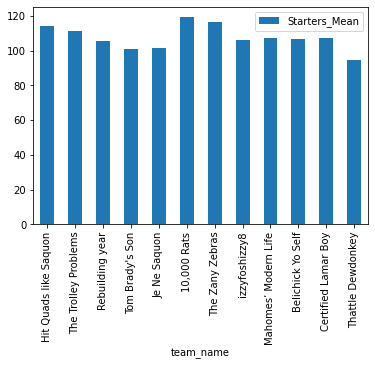

In [89]:
rosters_df.plot.bar(x='team_name', y='Starters_Mean')

### Import SI fantasy projections 2021

In [83]:
with open('sleeper_players.pkl', 'wb') as file:
    ffa_proj_df = pd.read_csv('ffa_all_09-16-2021.txt', sep='\t', index_col=False)
    ffa_proj_df['Player'] = ffa_proj_df['Player'].str.replace('.', '')
    ffa_proj_df['Player_Pos'] = ffa_proj_df['Player'] + ffa_proj_df['Position']
    # why is the abbr for vegas LVR rather than LV??? annoying
    ffa_proj_df['Team'].replace({'LVR': 'LV', 'JAC': 'JAX'}, inplace=True)
    # convert defense player names from common name to abbreviated to match sleeper
    ffa_proj_df.to_pickle('./ffa_proj.pkl')

ffa_proj_df.head()

<ipython-input-83-64cf43f37c63>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  ffa_proj_df['Player'] = ffa_proj_df['Player'].str.replace('.', '')


,Player,Team,Position,Floor,Mean,Ceiling,SD,Risk,VOR,Drop Off,Tier,ADP,Player_Pos
0,Kyler Murray,ARI,QB,22.3,24.2,27.4,1.97,5.13,0.0898,1.0,NaN,NaN,Kyler MurrayQB
1,Josh Allen,BUF,QB,22.0,24.1,27.0,1.80,5.40,0.1810,1.0,NaN,NaN,Josh AllenQB
2,Patrick Mahomes,KC,QB,21.3,23.9,26.5,1.99,5.27,1.1400,2.0,NaN,NaN,Patrick MahomesQB
3,Tom Brady,TB,QB,20.4,22.8,25.1,1.85,5.42,0.0368,2.0,NaN,NaN,Tom BradyQB
4,Lamar Jackson,BAL,QB,21.4,22.8,24.3,1.17,4.40,0.1350,2.0,NaN,NaN,Lamar JacksonQB


#### Sanitize SI Fantasy Football Rankings 2021

I didn't actually end up using this, the data was too gross

In [ ]:
with open('2021 SI Fantasy Football Rankings & Projections - Rosters.csv', newline='') as readfile:
    with open('SI_Projections_2021_Sanitizied.csv', 'w', newline='') as writefile:
        reader = csv.reader(readfile)
        writer = csv.writer(writefile)
        for row in reader:
            if not row[0].isupper(): # remove team name 
                if row[0] == '' and row[2]:
                    row[0] = 'Players'
                    if row[1] == '' and row[2]:
                        row[1] = 'Rank'
                writer.writerow(row)

In [ ]:
projectionsDF = pd.DataFrame()
l = []

with open('SI_Projections_2021_Sanitizied.csv', newline='') as fp:
    line = fp.readline()
    buffer = io.StringIO(line)
    while line:
        if line[0] != ',':
            buffer.write(line)
        elif buffer.tell():
            buffer.seek(0)
            curDF = pd.read_csv(buffer)
            curDF = curDF.loc[:, ~curDF.columns.str.contains('^Unnamed')]
#             projectionsDF = projectionsDF.append(curDF, ignore_index=True)
            l.append(curDF)
            buffer.close()
            curDF
            buffer = io.StringIO()
        line = fp.readline()
        
projectionsDF = pd.concat(l)